# Fraud Detection Models

This notebook aims to create a prediction of fraudulent purchasing in an e-commerce through both supervised and unsupervised machine learning modeling using data composed of devices and IP addresses, along with demographics used in both fraudulent and legitimate purchases.

***

## 1. Data Cleaning

In [1]:
# importing necessary libraries and modules

import numpy as np
import pandas as pd
import itertools

from scipy import special
from datetime import timedelta
from IPython.display import display

In [2]:
# reading necessary data
fraud_df = pd.read_csv('Fraud_Data.csv',header=0)
ISP_df = pd.read_csv('IpAddress_to_Country.csv',header=0)

In [3]:
# checking out the data types for the fraud dataset
fraud_df.dtypes

id                  int64
cadastro           object
compra             object
valor               int64
id_dispositivo     object
fonte              object
browser            object
genero             object
idade               int64
ip                float64
fraude              int64
dtype: object

In [4]:
# checking for null values for the fraud dataset
for col in fraud_df.columns:
    print('Null values in {}: {}'.format(col, fraud_df[col].isnull().sum()))

Null values in id: 0
Null values in cadastro: 0
Null values in compra: 0
Null values in valor: 0
Null values in id_dispositivo: 0
Null values in fonte: 0
Null values in browser: 0
Null values in genero: 0
Null values in idade: 0
Null values in ip: 0
Null values in fraude: 0


In [5]:
# describing the fraud dataset for the fraud dataset
fraud_df.describe()

,id,valor,idade,ip,fraude
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [6]:
# checking out the data types for the IP dataset
ISP_df.dtypes

limite_inferior_ip    float64
limite_superior_ip      int64
pais                   object
dtype: object

In [7]:
ISP_df.head()

,limite_inferior_ip,limite_superior_ip,pais
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [8]:
# upper and lower IP limits are in different data types.
# checking whether that was merely a dot by the end.

ip_floats = ISP_df.limite_inferior_ip.apply(lambda x: not x.is_integer()).sum()
print('Non-zero decimals in lower IP limits: {}'.format(ip_floats))

Non-zero decimals in lower IP limits: 0


In [9]:
# turning upper IP limit to a float64 so there'll be no errors in comparing the two datasets
ISP_df.limite_superior_ip = ISP_df.limite_superior_ip.astype(np.float64)
ISP_df.dtypes

limite_inferior_ip    float64
limite_superior_ip    float64
pais                   object
dtype: object

In [10]:
# checking for null values for the IP dataset
for col in ISP_df.columns:
    print('Null values in {}: {}'.format(col, ISP_df[col].isnull().sum()))

Null values in limite_inferior_ip: 0
Null values in limite_superior_ip: 0
Null values in pais: 0


In [11]:
# describing the fraud dataset for the IP dataset
ISP_df.describe()

,limite_inferior_ip,limite_superior_ip
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


In [12]:
# strange value at 75% percentile for the lower limit,
# checking whether it is merely a display issue

display(ISP_df[ISP_df.limite_inferior_ip == ISP_df.limite_inferior_ip.max()])
display(ISP_df[ISP_df.limite_superior_ip == ISP_df.limite_superior_ip.max()])

,limite_inferior_ip,limite_superior_ip,pais
138845,3.758096e+09,3.758096e+09,Australia


,limite_inferior_ip,limite_superior_ip,pais
138845,3.758096e+09,3.758096e+09,Australia


In [13]:
# defining which country an IP belongs to
def ip_to_country(ip):
    tmp = ISP_df[(ISP_df.limite_inferior_ip <= ip)
            & (ISP_df.limite_superior_ip >= ip)].pais
    if tmp.shape[0] == 1:
        return tmp.iloc[0]

fraud_df["pais"] = fraud_df.ip.apply(ip_to_country)
fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,None
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [14]:
fraud_df.to_csv("fraud_data_country.csv", index=False)

***

## 2. Exploratory Data Analysis

In [15]:
# importing necessary libraries

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

D:\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
# recreating the fraud dataset with country data

fraud_df = pd.read_csv("fraud_data_country.csv", header=0)
fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


Text(0, 0.5, 'Fraud cases')

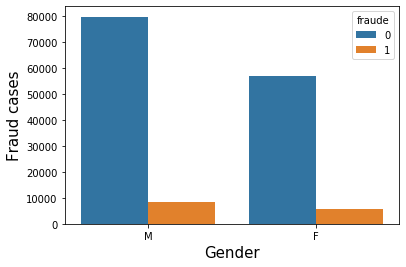

In [17]:
# creating a visualization of number of fraud cases by gender

sns.countplot(x="genero", hue="fraude", data=fraud_df)
plt.xlabel("Gender", fontsize=15)
plt.ylabel("Fraud cases", fontsize=15)

D:\Anaconda\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.42499999999999716, 0.5, 'Purchase value')

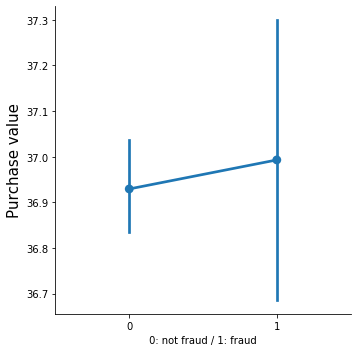

In [18]:
# plotting fraud cases by value
sns.factorplot(x="fraude", y="valor", data=fraud_df)
plt.xlabel(" 0: not fraud / 1: fraud ")
plt.ylabel("Purchase value", fontsize=15)

Text(-5.825000000000003, 0.5, "User's age")

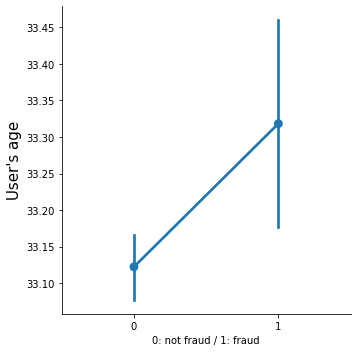

In [19]:
# reproducing the plot for user age

sns.factorplot(x="fraude",y="idade",data=fraud_df)
plt.xlabel("0: not fraud / 1: fraud")
plt.ylabel("User's age", fontsize=15)

Text(0, 0.5, 'Fraudulent cases')

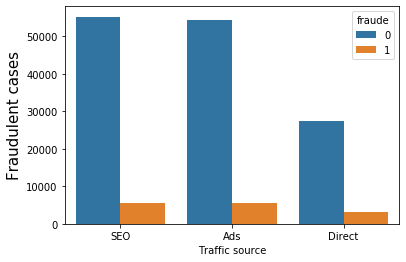

In [20]:
# plotting fraud by traffic source

sns.countplot(x="fonte",hue="fraude",data=fraud_df)
plt.xlabel("Traffic source")
plt.ylabel("Fraudulent cases", fontsize=15)

In [21]:
# grouping fraudulent purchases by country

fraud_sum = fraud_df[fraud_df['fraude'] == 1]["fraude"].groupby(fraud_df.pais).sum()
fraud_sum = fraud_sum.to_frame().reset_index()

not_fraud_sum = fraud_df[fraud_df["fraude"] == 0]["fraude"].groupby(fraud_df.pais).sum()
not_fraud_sum = not_fraud_sum.to_frame().reset_index()

Text(0, 0.5, 'Countries')

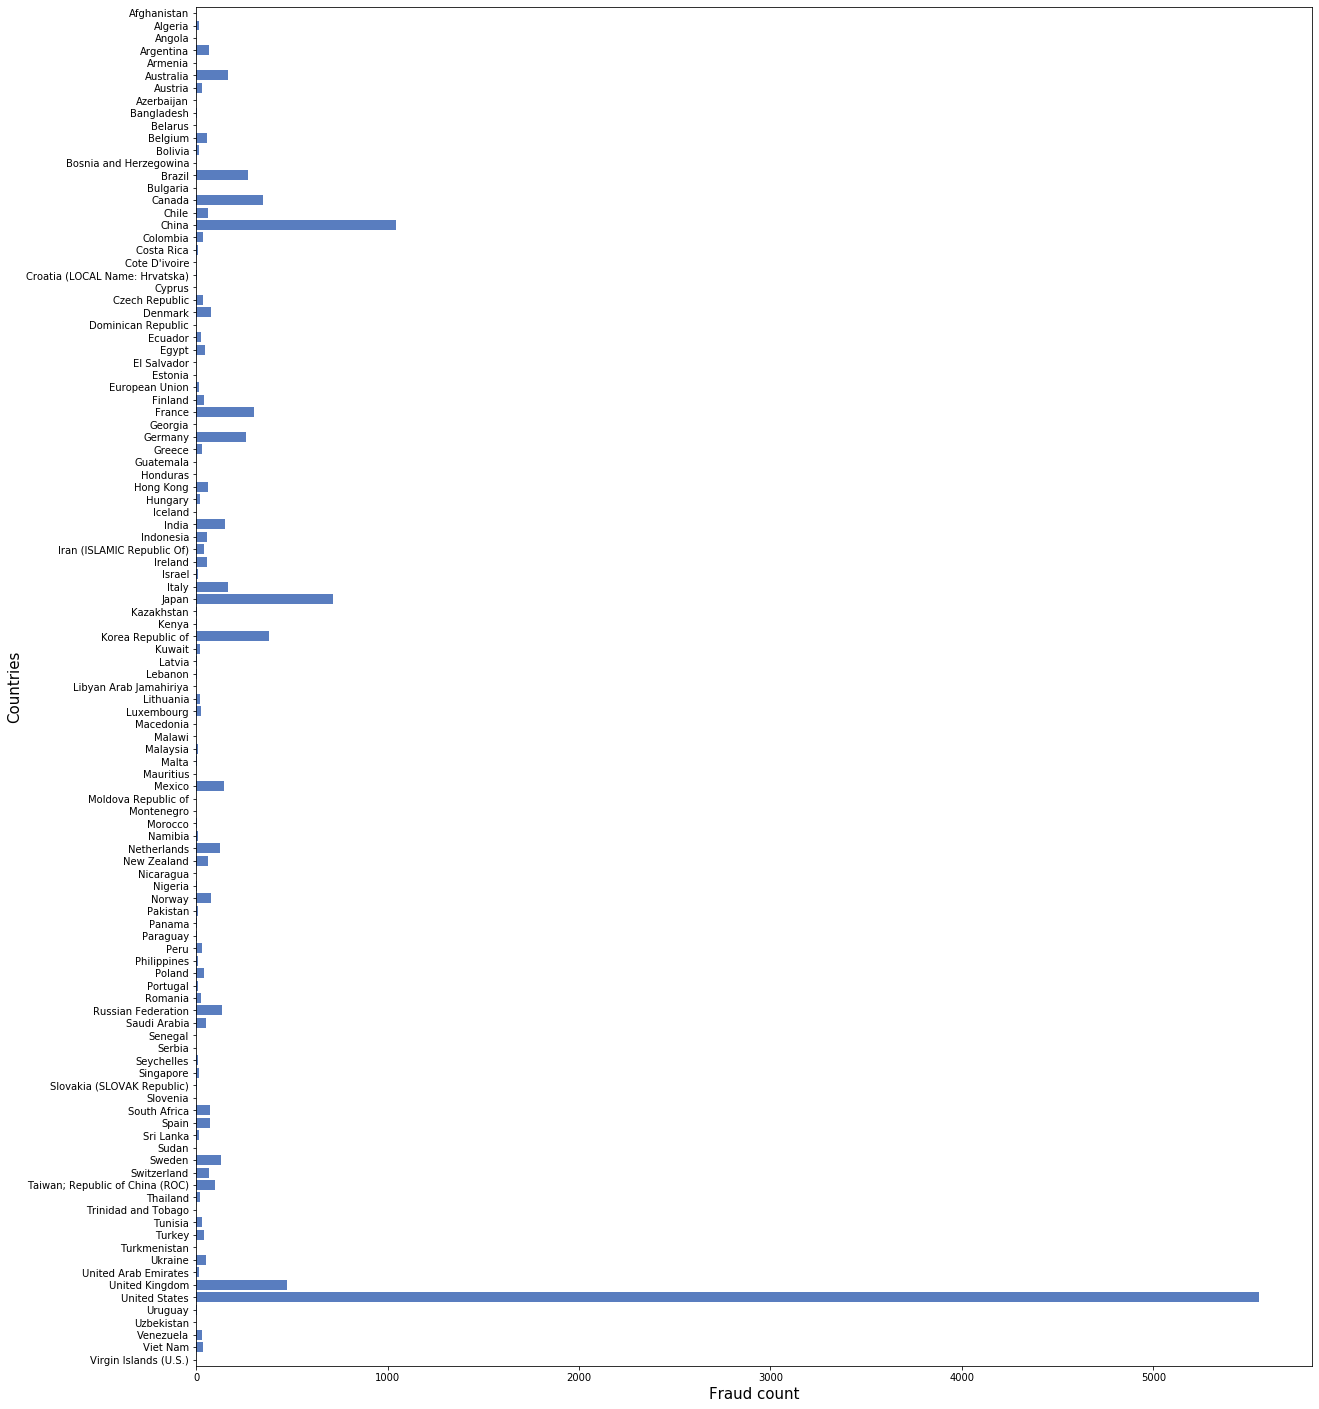

In [22]:
# plotting the fraud results

f, ax = plt.subplots(figsize=(20,25))
sns.set_color_codes("muted")
sns.barplot(x="fraude", y="pais", data=fraud_sum, label="Total", color="b")
plt.xlabel("Fraud count", fontsize=15)
plt.ylabel("Countries", fontsize=15)

In [23]:
# grouping data in a new dataframe

temp_df = pd.DataFrame(columns=("fraud","id_by_device","id_by_ip"))
temp_df["fraude"] = fraud_df["fraude"]

userid_device = fraud_df.groupby("id_dispositivo").id.count()
temp_df["id_by_device"] = fraud_df.id_dispositivo.apply(lambda x: userid_device[x])

userid_ip = fraud_df.groupby("ip").id.count()
temp_df["id_by_ip"] = fraud_df.ip.apply(lambda x: userid_ip[x])

In [24]:
# correcting error where fraud became NaN and a "fraude" column was imported
temp_df.fraud = temp_df.fraude
temp_df = temp_df.drop(['fraude'], axis=1)
temp_df.head()

,fraud,id_by_device,id_by_ip
0,0,1,1
1,0,1,1
2,1,12,12
3,0,1,1
4,0,1,1


D:\Anaconda\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(16.299999999999997, 0.5, 'User ID by IP')

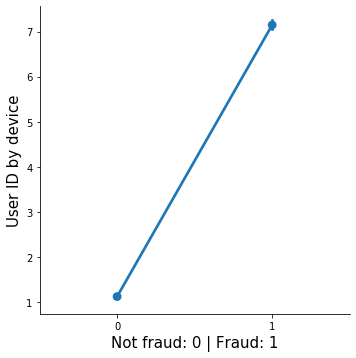

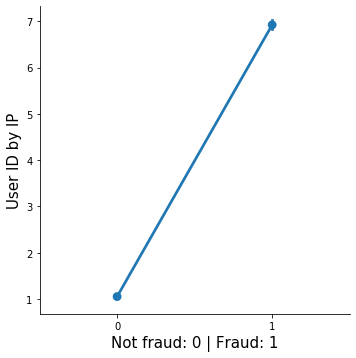

In [25]:
# plotting graphs for both new temporary datasets
sns.factorplot(x="fraud",y="id_by_device",data=temp_df)
plt.xlabel("Not fraud: 0 | Fraud: 1", fontsize=15)
plt.ylabel("User ID by device", fontsize=15)

sns.factorplot(x="fraud",y="id_by_ip",data=temp_df)
plt.xlabel("Not fraud: 0 | Fraud: 1", fontsize=15)
plt.ylabel("User ID by IP", fontsize=15)

In [26]:
# we find that there's a strong correlationg between
# several IPs and devices used by the same users to fraudulent transactions

# now checking how much time there is between registration and purchase

temp_df['registration'] = fraud_df.cadastro.apply(pd.to_datetime)
temp_df['purchase'] = fraud_df.compra.apply(pd.to_datetime)
temp_df['time_between'] = (temp_df.purchase - temp_df.registration).apply(lambda x: x.seconds)

Text(-8.825000000000003, 0.5, 'Time between registration and purchase')

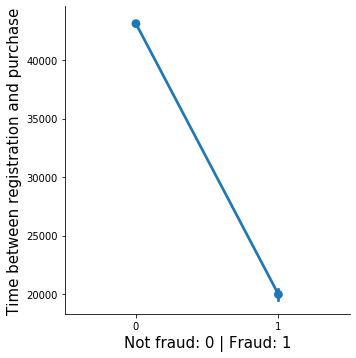

In [27]:
# plotting the time difference versus fraudulent activity

sns.factorplot(x="fraud",y="time_between",data=temp_df)
plt.xlabel("Not fraud: 0 | Fraud: 1", fontsize=15)
plt.ylabel("Time between registration and purchase", fontsize=15)

Text(0, 0.5, 'Fraud cases')

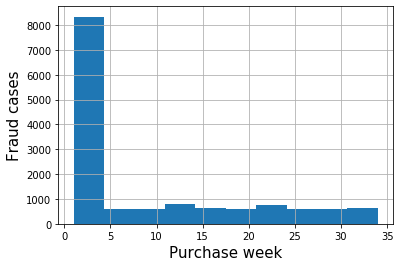

In [28]:
# Checking week of the year for frauds
# which will tell correlation at certain festivities

temp_df[temp_df['fraud'] == 1].registration.apply(lambda x: x.week).hist()
plt.xlabel("Purchase week", fontsize=15)
plt.ylabel("Fraud cases", fontsize=15)

***

## 3. Feature Engineering

In [29]:
# adding new feature for identifying multiple users in each device

users_by_device = fraud_df.groupby('id_dispositivo').id.count()
fraud_df['users_by_device'] = fraud_df.id_dispositivo.apply(lambda x: users_by_device[x])
fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,users_by_device
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1


In [30]:
# adding new feature for identifying multiple users in each IP

users_by_ip = fraud_df.groupby('ip').id.count()
fraud_df['user_by_ip'] = fraud_df.ip.apply(lambda x: users_by_ip[x])
fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,users_by_device,user_by_ip
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1


In [31]:
# adding average for the newly added columns

fraud_df['average_ids'] = (fraud_df.users_by_device + fraud_df.user_by_ip) * 0.5
fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,users_by_device,user_by_ip,average_ids
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1,1.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1,1.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12,12.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1,1,1.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1,1.0


In [32]:
# transforming registration and purchase to be actual date/times
fraud_df.cadastro = fraud_df.cadastro.apply(pd.to_datetime)
fraud_df.compra = fraud_df.compra.apply(pd.to_datetime)

# adding new feature for the amount of seconds between registration and purchase
fraud_df['time_between'] = (fraud_df.compra - fraud_df.cadastro).apply(lambda x: x.seconds)
fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,users_by_device,user_by_ip,average_ids,time_between
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1,1.0,13882
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1,1.0,17944
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12,12.0,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1,1,1.0,60085
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1,1.0,41461


In [33]:
# transforming countries into a dummy variable

country_dummy = pd.get_dummies(fraud_df.pais, prefix="country_")
fraud_df = pd.concat([fraud_df, country_dummy], axis=1)
fraud_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,...,country__United States,country__Uruguay,country__Uzbekistan,country__Vanuatu,country__Venezuela,country__Viet Nam,country__Virgin Islands (U.S.),country__Yemen,country__Zambia,country__Zimbabwe
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,0,0,0,0,0,0,0,0,0,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,1,0,0,0,0,0,0,0,0,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,1,0,0,0,0,0,0,0,0,0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,0,0,0,0,0,0,0,0,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,1,0,0,0,0,0,0,0,0,0


In [34]:
# removing irrelevant columns for performance

fraud_df.drop(["id",
              "cadastro",
              "compra",
              "id_dispositivo",
              "users_by_device",
              "user_by_ip",
              "pais",
              "fonte",
              "browser",
              "genero",
              "idade",
              "valor"], axis=1, inplace=True)

fraud_df.head()

,ip,fraude,average_ids,time_between,country__Afghanistan,country__Albania,country__Algeria,country__Angola,country__Antigua and Barbuda,country__Argentina,...,country__United States,country__Uruguay,country__Uzbekistan,country__Vanuatu,country__Venezuela,country__Viet Nam,country__Virgin Islands (U.S.),country__Yemen,country__Zambia,country__Zimbabwe
0,7.327584e+08,0,1.0,13882,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.503114e+08,0,1.0,17944,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2.621474e+09,1,12.0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,3.840542e+09,0,1.0,60085,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.155831e+08,0,1.0,41461,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


D:\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\hist.py:309: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


Text(0, 0.5, 'Normalized count')

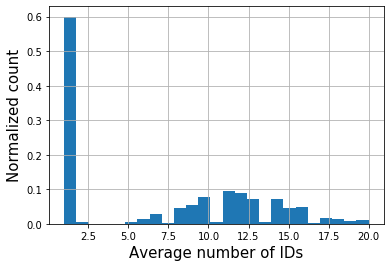

In [35]:
# checking the features to see if they behave in a Gaussian manner

fraud_df[fraud_df["fraude"] == 1].average_ids.hist(normed=True,bins=25)
plt.xlabel("Average number of IDs", fontsize=15)
plt.ylabel("Normalized count", fontsize=15)

Text(0, 0.5, 'Normalized count')

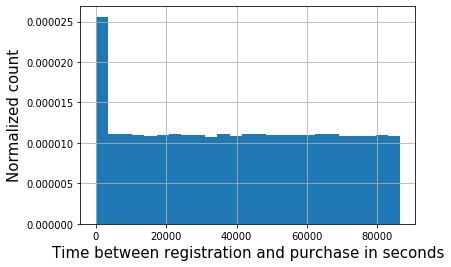

In [36]:
# the average number of IDs behaves such way, and is bi-modal
# replicating the same analysis for the time between registration and purchase

fraud_df.time_between.hist(normed=True, bins=25)
plt.xlabel("Time between registration and purchase in seconds", fontsize=15)
plt.ylabel("Normalized count", fontsize=15)

In [37]:
# aside from time between 0-1 seconds (approximately), the distribution is pretty much flat
# defining a function to mathematically transform the series into a normal distribution

def rescale_series(series):
    series_minimum = series.min() - 1e-5
    series_maximum = series.max() + 1e-5
    new_series = (series - series_minimum) / (series_maximum - series_minimum)
    new_series = new_series.apply(lambda x: np.sqrt(2) * special.erfinv(2*x - 1))
    return new_series

Text(0, 0.5, 'Normalized count')

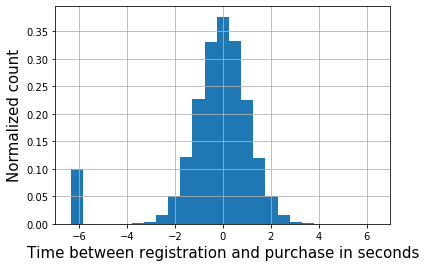

In [38]:
# applying function to the time between variable

fraud_df["time_between"] = rescale_series(fraud_df.time_between)
fraud_df.time_between.hist(normed=True, bins=25)
plt.xlabel("Time between registration and purchase in seconds", fontsize=15)
plt.ylabel("Normalized count", fontsize=15)

In [39]:
# defining function for scaling the entire dataset, with exception of boolean values

def rescale_feature(column):
    column_minimum = column.min() - 1e-5
    column_maximum = column.max() + 1e-5
    new_series = (column - column_minimum) / (column_maximum - column_minimum)
    return new_series

In [40]:
# applying the scaling

onehotencoded = [feature for feature in fraud_df.columns if 'country' not in feature and feature != 'fraude']

for column in onehotencoded:
    fraud_df[column] = rescale_feature(fraud_df[column])

X = fraud_df[ [column for column in fraud_df.columns if column != 'fraude'] ]
y = fraud_df['fraude']

In [41]:
# exporting X and y to external files for future usage

X.to_csv('X.csv', index=False)
y.to_csv('y.csv', index=False)

In [42]:
# importing library from sklearn
from sklearn.ensemble import ExtraTreesClassifier

In [43]:
# fitting the features

clf = ExtraTreesClassifier()
_ = clf.fit(X, y)

# organizing features by importance
features = pd.DataFrame()
features['feature'] = X.columns
features['feature_importance'] = clf.feature_importances_

features[features.feature_importance > np.mean(features.feature_importance)].sort_values(by="feature_importance", ascending=False)

,feature,feature_importance
2,time_between,0.498302
1,average_ids,0.273246
0,ip,0.221068


***

## 4. Predictive Modeling

In [44]:
# importing machine learning libraries

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import f1_score

In [45]:
# Making the splits

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state=42)
y_train = y_train.apply(lambda x: 1 if x == 0 else -1)
y_test = y_test.apply(lambda x: 1 if x == 0 else -1)

In [46]:
# Setting the parameters

IF = IsolationForest(max_samples="auto", contamination=0.095, random_state=42)
parameter_grid = {"n_estimators": [100, 150, 200, 250, 300, 350, 400, 450, 500]}
clf = GridSearchCV(IF,
                  parameter_grid,
                  cv=5,
                  n_jobs=10,
                   scoring='f1',
                   verbose=10
                  )

_ = clf.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  4.1min
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  8.2min
[Parallel(n_jobs=10)]: Done  31 out of  45 | elapsed: 14.0min remaining:  6.3min
[Parallel(n_jobs=10)]: Done  36 out of  45 | elapsed: 16.8min remaining:  4.2min
[Parallel(n_jobs=10)]: Done  41 out of  45 | elapsed: 18.9min remaining:  1.8min
[Parallel(n_jobs=10)]: Done  45 out of  45 | elapsed: 18.9min finished


              precision    recall  f1-score   support

   anomalous       0.51      0.51      0.51      3563
      normal       0.95      0.95      0.95     34215

    accuracy                           0.91     37778
   macro avg       0.73      0.73      0.73     37778
weighted avg       0.91      0.91      0.91     37778

Area under the curve: 0.732


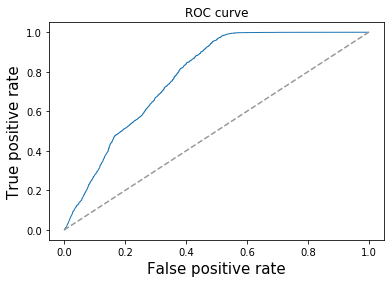

In [47]:
# setting up the prediction

IF_best = clf.best_estimator_
y_pred = IF_best.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=["anomalous", "normal"]))
print("Area under the curve: {:0.3f}".format(roc_auc))

IF_probabilities = IF_best.decision_function(X_test)
fpr, tpr, threshold = roc_curve(y_test, IF_probabilities)

plt.plot(fpr, tpr, lw=1)
plt.plot([0,1],[0,1],'--',color=(0.6, 0.6, 0.6), label="sheer luck")
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel("False positive rate", fontsize=15)
plt.ylabel("True positive rate", fontsize=15)
plt.title("ROC curve", fontsize=12)
plt.show()

In [48]:
# checking the confusion matrix

from sklearn.metrics import confusion_matrix

In [49]:
cnf_matrix_IF = confusion_matrix(y_test, y_pred)
print(cnf_matrix_IF)

[[ 1833  1730]
 [ 1756 32459]]


In [50]:
# the point of the model is to bring down the false negatives, checking if better scores are achieved with unsupervised models